# Energy Consortium Ltd. Energy Trends Machine Learning Project

This project involves  a machine learning application that analyzes energy consumption trends and make accurate predictions. This application is a decision-support tool, allowing stakeholders to understand energy patterns and potentially influence policy-making towards sustainable practices.
Through the RandomForestRegressor algorithm, this application has demonstrated a capability to handle the intricacies of global energy consumption data. It provides the consortium with a powerful tool to predict future energy needs based on various socio-economic indicators, thus contributing to informed decision-making


In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

In [75]:
# Read csv data
df = pd.read_csv("world-consumption.csv")
df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


# Preprocessing

In [56]:
#Define the list of columns to keep for analysis
columns_to_keep = [
    'country',
    'year',
    'population',
    'gdp',
    'renewables_consumption',
    'fossil_fuel_consumption',
]

# Filter the DataFrame to only include rows where the 'year' is between 1965 and 2022, the periods where data is available
df_filtered = df[(df['year'] >= 1965) & (df['year'] <= 2022)]

# Select only the columns of interest
data = df_filtered[columns_to_keep]

# Save filtered DataFrame to a new csv file
data.to_csv('energy_consumption_data.csv', index=False)

# Import the filtered data
df_energy = pd.read_csv('energy_consumption_data.csv')

In [57]:
# Step 1: Generate the mapping from country names to codes
country_to_code = {name: code for code, name in enumerate(df_energy['country'].astype('category').cat.categories)}

# Step 2: Convert the 'country' column to codes
df_energy['country'] = df_energy['country'].astype('category').cat.codes

In [58]:
# Check missing data
df_energy.isnull().sum()/len(df_energy)

country                    0.000000
year                       0.000000
population                 0.213778
gdp                        0.460187
renewables_consumption     0.617975
fossil_fuel_consumption    0.654023
dtype: float64

In [59]:
# Fill numeric rows with the median
for label, content in df_energy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill missing numeric values with median
            df_energy[label] = content.fillna(content.median())

In [60]:
# Check for which numeric columns have null values
for label, content in df_energy.items():
    if pd.api.types.is_numeric_dtype(content):
       if pd.isnull(content).sum():
            print(label)

In [61]:
# Check if any data still missing
df_energy.isna().sum()

country                    0
year                       0
population                 0
gdp                        0
renewables_consumption     0
fossil_fuel_consumption    0
dtype: int64

## Descriptive method: analyzing the dataset

In this section, we use matplotlib to develop plots to gain more insight into the dataset.

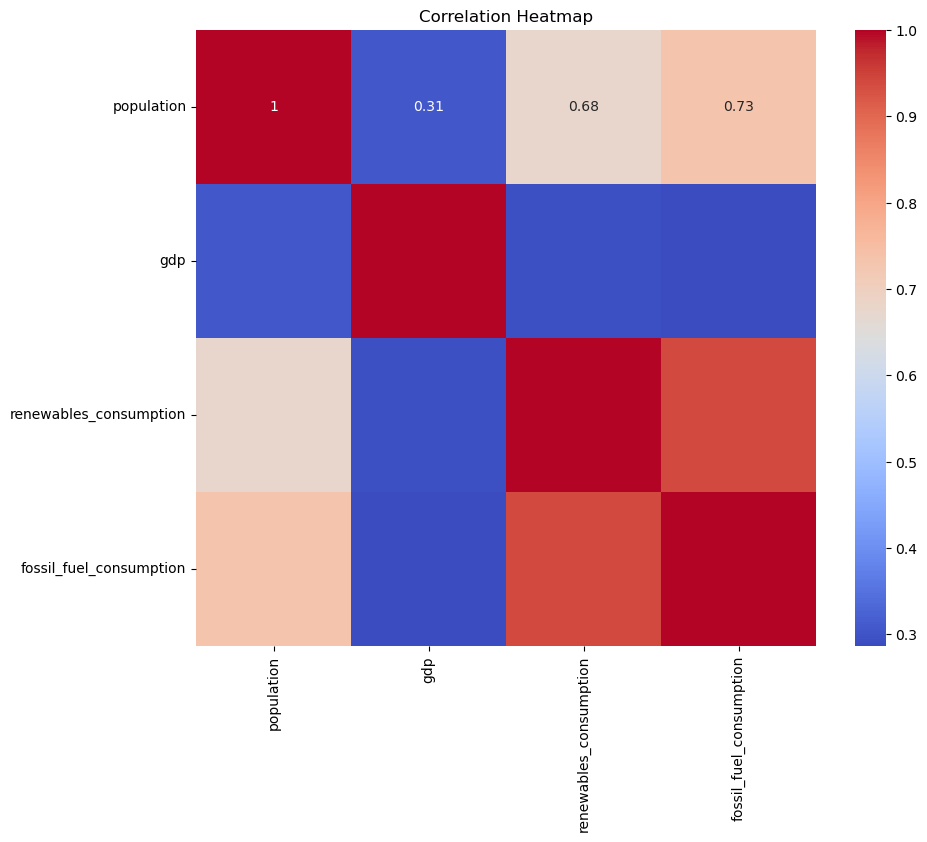

In [79]:
# Plot 1: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df_energy[['population', 'gdp', 'renewables_consumption', 'fossil_fuel_consumption']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

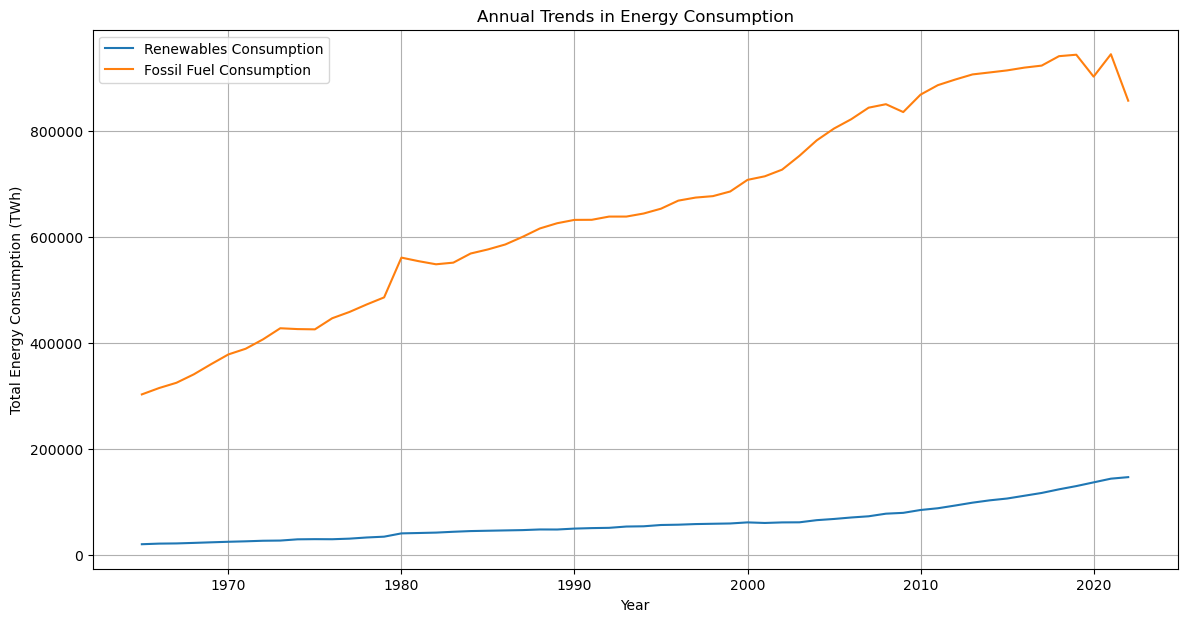

In [80]:
# Plot 2: Trend Line for Renewables vs. Fossil Fuel Consumption Across Years
plt.figure(figsize=(14, 7))
df_energy.groupby('year')['renewables_consumption'].sum().plot(label='Renewables Consumption')
df_energy.groupby('year')['fossil_fuel_consumption'].sum().plot(label='Fossil Fuel Consumption')
plt.title('Annual Trends in Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption (TWh)')
plt.legend()
plt.grid(True)
plt.show()

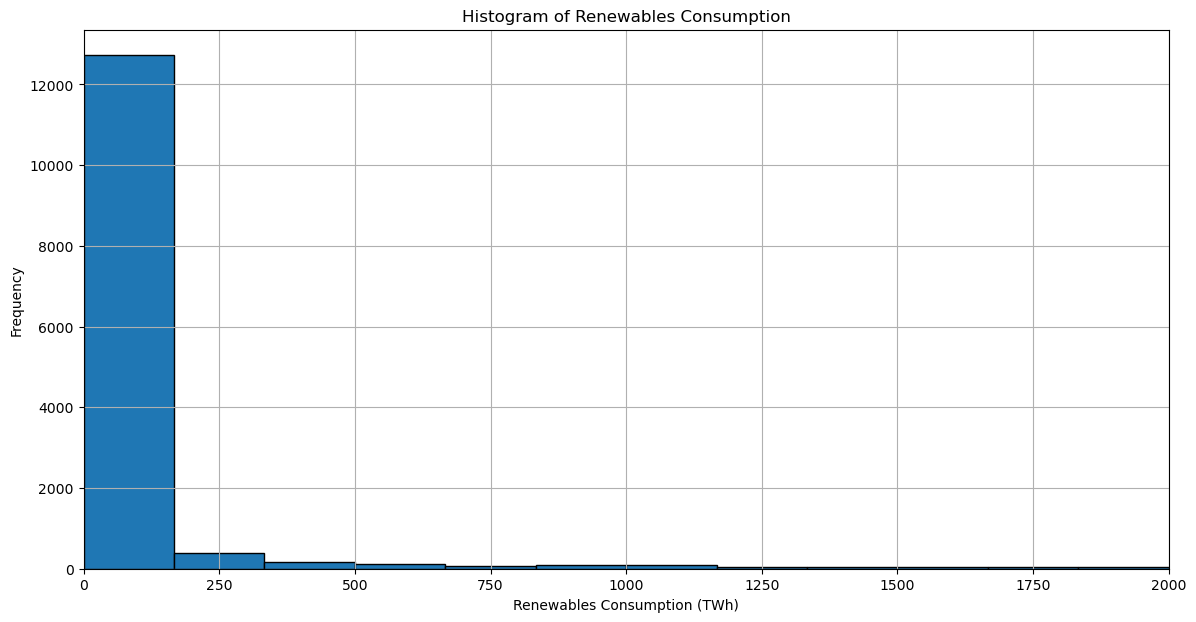

In [81]:
# Plot 3: Histogram of renewables consumption
plt.figure(figsize=(14, 7))
df_energy['renewables_consumption'].hist(bins=30, edgecolor='black', range=(0, 5000))  # Adjust the range as needed
plt.title('Histogram of Renewables Consumption')
plt.xlabel('Renewables Consumption (TWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0, 2000)  # Set the limits of the x-axis
plt.show()


## Modelling

In this section, we prepare, train, and evaluate the model.

In [66]:
# Split data into training and validation
df_val = df_energy[df_energy.year == 2020]
df_train = df_energy[df_energy.year != 2020]

len(df_val), len(df_train)

(285, 14057)

In [67]:
# Split data into x (features) and y (targets)
X_train = df_train.drop(['renewables_consumption', 'fossil_fuel_consumption'], axis=1)
y_train_renewables = df_train['renewables_consumption']
y_train_fossil = df_train['fossil_fuel_consumption']

X_valid = df_val.drop(['renewables_consumption', 'fossil_fuel_consumption'], axis=1)
y_valid_renewables = df_val['renewables_consumption']
y_valid_fossil = df_val['fossil_fuel_consumption']

y_train_renewables.shape, y_train_fossil.shape, X_valid.shape, y_valid_renewables.shape, y_valid_fossil.shape

((14057,), (14057,), (285, 4), (285,), (285,))

In [68]:
# Fit separate models for each target variable
model_renewables = RandomForestRegressor(n_jobs=-1, random_state=42)
model_renewables.fit(X_train, y_train_renewables)

model_fossil = RandomForestRegressor(n_jobs=-1, random_state=42)
model_fossil.fit(X_train, y_train_fossil)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [69]:
# Evaluation function
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Evaluation function
def show_scores(model, X_train, y_train, X_valid, y_valid, target_name=""):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        f"Training MAE {target_name}": mean_absolute_error(y_train, train_preds),
        f"Valid MAE {target_name}": mean_absolute_error(y_valid, val_preds),
        f"Training RMSLE {target_name}": np.sqrt(mean_squared_log_error(y_train, train_preds)),
        f"Valid RMSLE {target_name}": np.sqrt(mean_squared_log_error(y_valid, val_preds)),
        f"Training R^2 {target_name}": r2_score(y_train, train_preds),
        f"Valid R^2 {target_name}": r2_score(y_valid, val_preds)
    }
    return scores

# Assuming you have two models: one for renewables and one for fossil fuel consumption
renewables_scores = show_scores(model_renewables, X_train, y_train_renewables, X_valid, y_valid_renewables, "Renewables")
fossil_scores = show_scores(model_fossil, X_train, y_train_fossil, X_valid, y_valid_fossil, "Fossil")

print(renewables_scores)
print(fossil_scores)

{'Training MAE Renewables': 4.839816259514881, 'Valid MAE Renewables': 22.769140842105372, 'Training RMSLE Renewables': 0.2471532174868035, 'Valid RMSLE Renewables': 0.34168614627051436, 'Training R^2 Renewables': 0.9990576773743007, 'Valid R^2 Renewables': 0.998616681706725}
{'Training MAE Fossil': 24.327809636481653, 'Valid MAE Fossil': 174.00036122807182, 'Training RMSLE Fossil': 0.11542733779960744, 'Valid RMSLE Fossil': 0.2525704254622618, 'Training R^2 Fossil': 0.9998437666863139, 'Valid R^2 Fossil': 0.9973525808048596}


## User Interface

This section provides the uder with a widget to make energy predictions.

To use it:
1. Input the desired country name, year, population, and GDP values into the corresponding fields.2. 	Click the "Predict" button to generate renewable and fossil fuel consumption forecasts based on your inputs

In [82]:
# Suppose you have already trained your models and have df_train and df_val ready.
# Here df_train['country'] should already be in categorical code format.

# Create the reverse mapping from codes to country names
code_to_country = {code: name for name, code in country_to_code.items()}

# User Interface Components
country_input = widgets.Dropdown(options=[(code_to_country[code], code) for code in sorted(code_to_country)], description='Country:')
year_input = widgets.IntText(value=2022, description='Year:')
population_input = widgets.FloatText(value=0.0, description='Population:')
gdp_input = widgets.FloatText(value=0.0, description='GDP:')

predict_button = widgets.Button(description='Predict')
output = widgets.Output()

def on_predict_button_clicked(b):
    with output:
        output.clear_output()  # Clear the previous output
        try:
            # Since the dropdown is already giving us the country code, we don't need to map it again
            country_code = country_input.value
            
            # Constructing a DataFrame from the input
            input_df = pd.DataFrame({
                'country': [country_code],  # Use the country code directly
                'year': [year_input.value],
                'population': [population_input.value],
                'gdp': [gdp_input.value]
            })
            
            # Make predictions using the model
            renewables_pred = model_renewables.predict(input_df)
            fossil_pred = model_fossil.predict(input_df)
            
            # Display predictions
            print(f"Predicted Renewables Consumption: {renewables_pred[0]}")
            print(f"Predicted Fossil Fuel Consumption: {fossil_pred[0]}")
        except Exception as e:
            print(f"An error occurred: {e}")  # This will print the actual exception

# Link the button click event to the function
predict_button.on_click(on_predict_button_clicked)

# Display the UI components
display(country_input, year_input, population_input, gdp_input, predict_button, output)


Dropdown(description='Country:', options=(('ASEAN (Ember)', 0), ('Afghanistan', 1), ('Africa', 2), ('Africa (E…

IntText(value=2022, description='Year:')

FloatText(value=0.0, description='Population:')

FloatText(value=0.0, description='GDP:')

Button(description='Predict', style=ButtonStyle())

Output()